(1)셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


# 얼굴 검출 & 랜드마크 검출 하기

## 이미지 불러오기

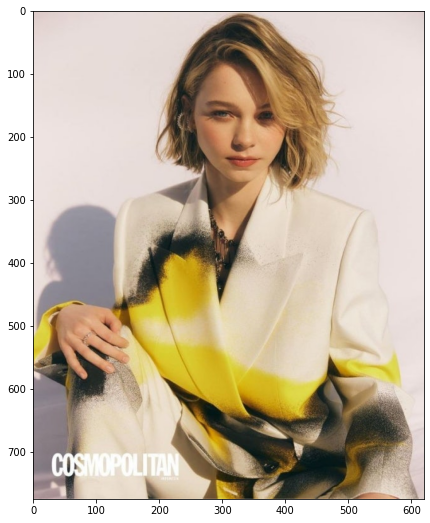

In [2]:
img_bgr = cv2.imread('./emma_fr.png')    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 이미지 출력
def print_img(img, BGR2RGB=True):
    plt.figure(figsize=(7,9))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if BGR2RGB else img)
    plt.show()

print_img(img_bgr)

## 얼굴 검출

In [3]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 초기화

In [4]:
# 얼굴 감지 영역 좌표
dlib_rects = detector_hog(img_show, 1)
print(dlib_rects) 

rectangles[[(253, 133) (408, 288)]]


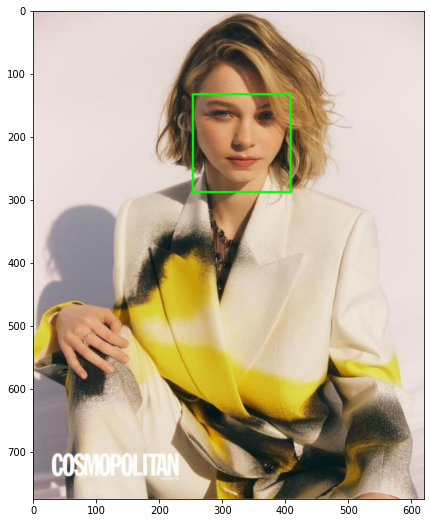

In [5]:
# 시작점의 좌표와 종료점 좌표로 바운딩 박스 그리기

def draw_bbox(dlib_rects, img):
    # 여러 얼굴이 있을 경우를 생각하여 for문으로 작성
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        
        cv2.rectangle(img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

draw_bbox(dlib_rects, img_show)
print_img(img_show)

## 랜드마크 검출

In [6]:
# landmark 모델 경로
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

def get_landmarks(dlib_rects, img):
    list_landmarks = []
    
    for dlib_rect in dlib_rects:
        # 모든 landmark의 위치정보 points 변수에 저장
        points = landmark_predictor(img, dlib_rect)
        
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
        # 해당 얼굴의 landmark정보를 list_landmarks에 저장
        list_landmarks.append(list_points)
    
    return list_landmarks
    
# 원소 개수 확인
temp_points = get_landmarks(dlib_rects, img_show)
len(temp_points[0])

68

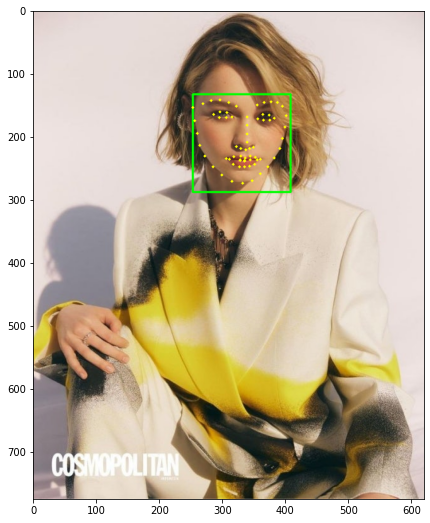

In [7]:
# 랜드마크 그리기

def draw_landmarks(list_landmarks, img):
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img, point, 2, (0, 255, 255), -1)
            
draw_landmarks(temp_points, img_show)
print_img(img_show)

# 스티커 적용 위치 확인하기

## 스티커 위치 정하기

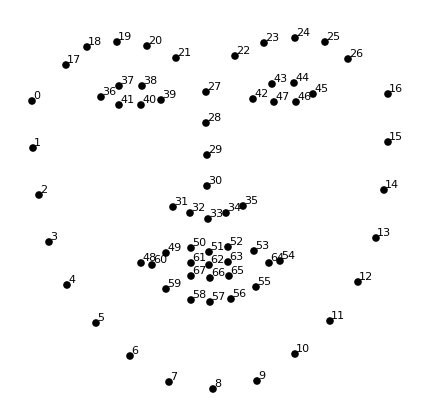

- 실제 사진을 참고하여 고양이코(스티커)의 두께를 생각하면 코 끝부분인 30번보다 콧등 밑 부분인 29번이 적절해 보인다.

In [8]:
# 스티커 위치 좌표 및 너비 구하기
def get_coords(dlib_rects, list_landmarks):
    coords = []
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # x, y는 콧등 아랫부분 위치와 동일
        x = landmark[29][0]
        y = landmark[29][1]
        
        # w는 얼굴 영역 너비와 동일
        w = dlib_rect.width()
        
        # 원본 이미지에서 이미지 좌표
        refined_x = x - w // 2
        refined_y = y
        
        coords.append([refined_x, refined_y, w])
        
    return coords

coords = get_coords(dlib_rects, temp_points)
coords

[[261, 196, 156]]

## 스티커 불러오기

In [9]:
img_sticker = cv2.imread('./cat-whiskers.png', cv2.IMREAD_UNCHANGED)

img_sticker.shape

(512, 512, 4)

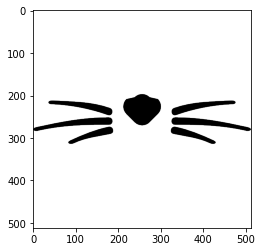

In [10]:
# 이미지 출력
plt.imshow(img_sticker)
plt.show()

- 스티커에 불필요하게 Y축 빈 공간이 많다.
- 스티커의 위치를 저 비어있는 공간 시작점을 고려해야 하는데 이 부분은 합리적이지 않다고 판단.
- 실제로 유효한 스티커의 상단과 하단의 y값을 구해서 이미지를 잘라서 쓰기로 한다.

In [11]:
y_area = []

# 픽셀 값을 순회하며 알파값이 투명(0)이 아닌 지점의 y값들을 저장한다.
for i in range(len(img_sticker)):
    for j in img_sticker[i]:
        if j[3]:
            y_area.append(i)

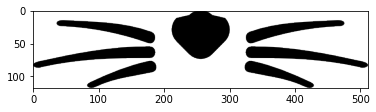

In [12]:
# 이미지 출력
plt.imshow(img_sticker[min(y_area):max(y_area)+1])
plt.show()

In [13]:
# 자른 이미지로 교체 및 알파 채널 삭제
img_sticker = img_sticker[min(y_area):max(y_area)+1][:, :, :3]

# 가로 대비 세로 비율 저장
wh_ratio = img_sticker.shape[0] / img_sticker.shape[1]
wh_ratio

0.23046875

In [14]:
img_sticker.shape

(118, 512, 3)

## 스티커 위치 확인

### `cv2.addWeighted()` 적용하여 투명한 스티커 적용
- 스티커 뒤로 원본 이미지가 같이 보이도록 투명하게 만들고자 한다.

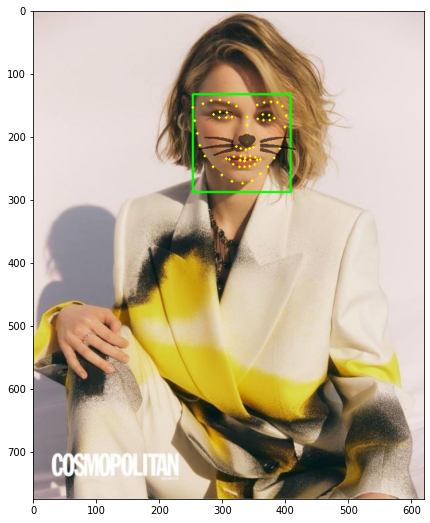

In [15]:
def get_sticker(img, img_sticker, coords, wh_ratio, alpha=0.6):
    # 스티커 붙이기
    for x, y, w in coords:
        new_sticker = img_sticker.copy()
        # 스티커 이미지 크기 조정
        new_sticker = cv2.resize(new_sticker, (w,int(w*wh_ratio)))
        
        # 이미 범위 밖으로 넘어가능 경우 자르기
        if x < 0: 
            new_sticker = new_sticker[:, -x:]
            x = 0
        if y < 0:
            new_sticker = new_sticker[-y:, :]
            y = 0
        
        sticker_area = img[y:y +new_sticker.shape[0], x:x+new_sticker.shape[1]]
        img[y:y +new_sticker.shape[0], x:x+new_sticker.shape[1], :] = \
            cv2.addWeighted(sticker_area, 1-alpha, 
                            np.where(new_sticker!=0,sticker_area,new_sticker).astype(img_show.dtype), alpha, 0)
    
    return img

img_with_stk = get_sticker(img_show, img_sticker, coords, wh_ratio, 0.6)
print_img(img_with_stk)

- 적당한 위치에 잘 놓인 것 같다.

# 스티커 적용하기

- Bounding Box, Landmark 표시 없는 원본 이미지에 결과 출력

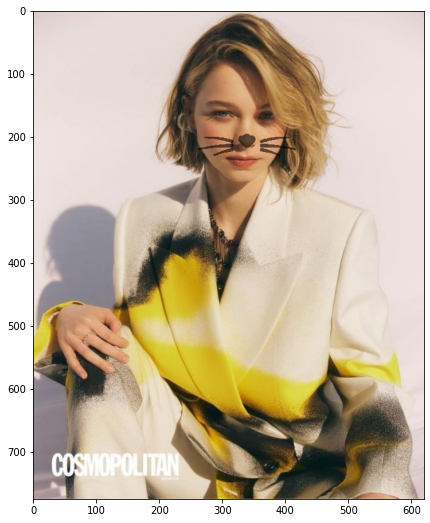

In [16]:
img_with_stk = get_sticker(img_bgr, img_sticker, coords, wh_ratio)
print_img(img_with_stk)

## 스티커 적용 함수화

- 이후 여러 이미지에 바로 적용하고 문제를 확인해보기 위해 위 일련의 과정을 함수화 한다.

In [17]:
def stickerApp(img, bbox=False, landmarks=False):
    
    # 얼굴 검출
    dlib_rects = detector_hog(img, 1)
    
    # 실패 시 종료
    if not dlib_rects:
        print("Face Detection Failure")
        return
    
    # 필요시 바운딩 박스 그리기
    if bbox == True:
        draw_bbox(dlib_rects, img)
    
    # 랜드마크 검출
    list_landmarks = get_landmarks(dlib_rects, img)
    
    # 실패 시 종료
    if not list_landmarks:
        print("Landmark Detection Failure")
        return
    
    # 필요시 랜드마크 그리기
    if landmarks == True:
        draw_landmarks(list_landmarks, img)
    

    # 스티커 위치 좌표 및 너비 구하기
    coords = get_coords(dlib_rects, list_landmarks)

    # 스티커 적용
    img_with_stk = get_sticker(img, img_sticker, coords, wh_ratio, 0.6)
    
    # 이미지 출력
    print_img(img_with_stk)

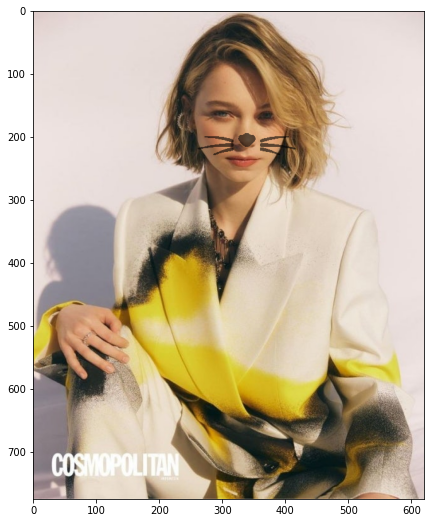

In [18]:
img_bgr = cv2.imread('./emma_fr.png')
stickerApp(img_bgr)

# 문제점 찾아보기

## Case1. 눈코입 일부가 보이지 않는 경우

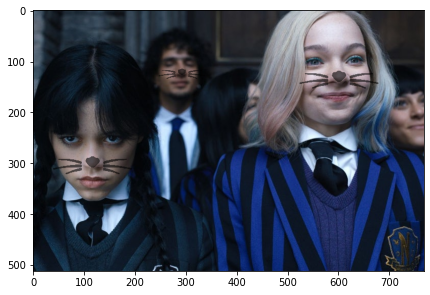

In [19]:
stickerApp(cv2.imread('./emma_wed.png'))

- 맨 오른쪽 사람에 스티커가 적용되지 않는 문제 발견
- 바운딩 박스와 랜드마크 확인

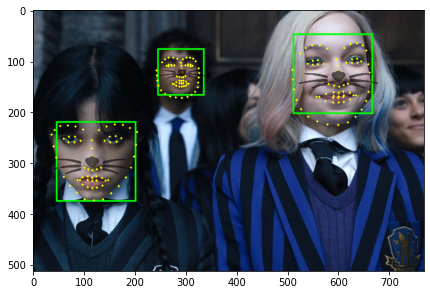

In [20]:
stickerApp(cv2.imread('./emma_wed.png'), True, True)

- 눈이 한 쪽 가려지면서 얼굴로 인식하지 않는 것으로 예상
- 기존 이미지에서 인식된 얼굴의 일부분 가리고 다시 테스트

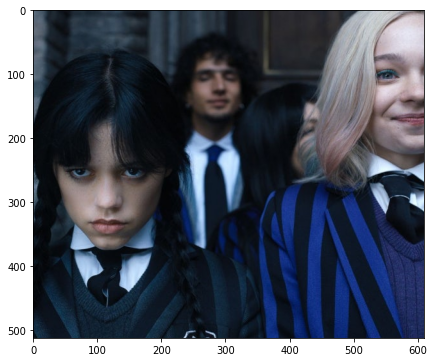

In [21]:
sliced = cv2.imread('./emma_wed.png')[:, :610]
print_img(sliced)

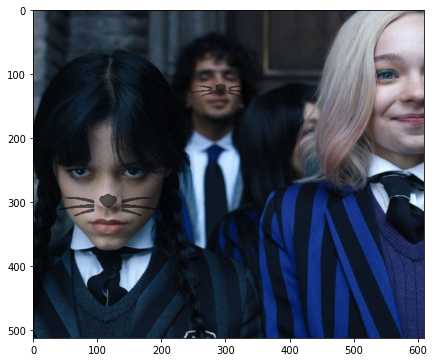

In [23]:
stickerApp(sliced)

- 역시 얼굴 전체가 잘 보이지 않으면 인식 불가
---

## Case2. 살짝 회전이 있는 흑백사진

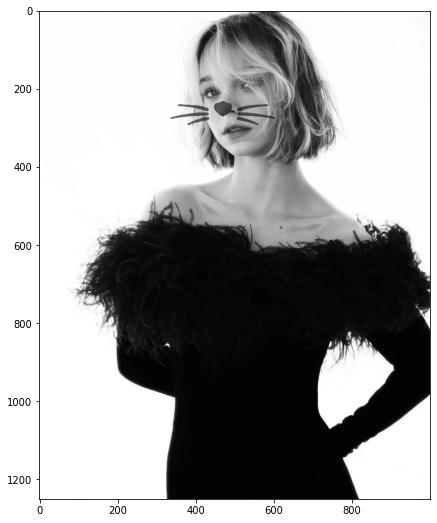

In [23]:
stickerApp(cv2.imread('./emma_l.png'))

- 흑백사진에서도 얼굴 검출은 잘 되는 것으로 확인
- 어색함 발견. 바운딩 박스를 그려서 확인.

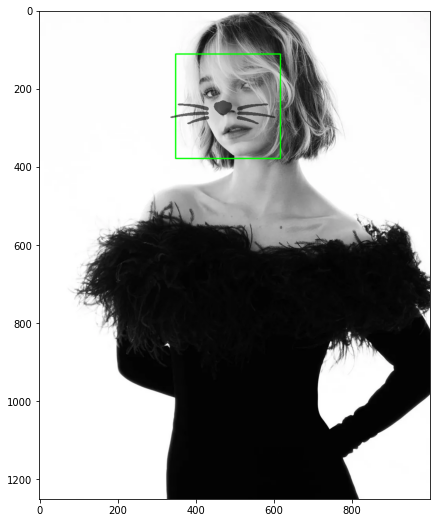

In [24]:
stickerApp(cv2.imread('./emma_l.png'), True)

- 얼굴의 회전각도는 고려하지 않은채 코를 중심으로 좌우 면적이 동일하도록 바운딩 박스가 그려짐
    - 즉, 바운딩박스가 얼굴이 카메라 정면을 보고 있는 경우만 고려했다.
    
- 스티커 또한 회전값을 고려하지 않은채 바운딩박스 기준으로 그려져 있기 때문에 어색함이 나타난다.
    - 즉, 스티커가 얼굴의 회전을 고려하여 함께 회전하여야 어색함을 줄일 수 있을 것이다.
    
- 얼굴이 약간 기울어져 있으나 스티커는 같이 기울어지지 않아서 더욱 어색함.

---

## Case3. 아주 살짝 회전이 있는 얼굴 비율이 큰 사진

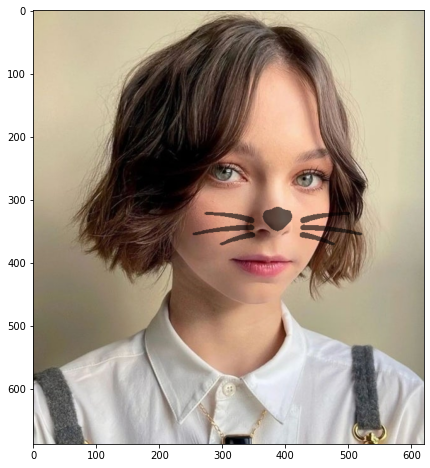

In [25]:
stickerApp(cv2.imread('./emma_r.png'))

- 이 경우는 회전각도가 크지 않아서 그만큼 덜 어색하긴 하다.

- 다만, 사진 기준 오른쪽으로 약간 회전을 했으나 이를 고려하지 않았기 때문에 왼쪽 수염을 코에 붙은 반면 오른쪽은 약간 떨어져 있는 이상한 부분이 발생한다.

- 직전 사진과 유사한 문제

- 얼굴이 사진에서 차지하는 비율이 크다보니 스티커도 함께 커지면서 어색한 부분이 더 눈에 띄는 것 같다. 얼굴이 좀 작은 사진에서는 티가 좀 덜 나긴 함.

---

## Case4. 옆모습의 얼굴 비율이 다소 작은 사진

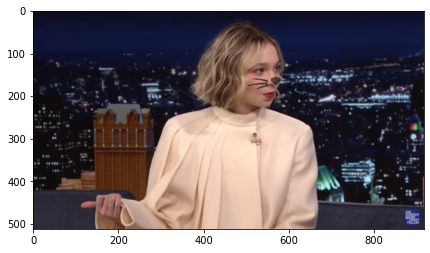

In [26]:
stickerApp(cv2.imread('./emma_side.png'))

- 좀 더 회전이 큰 옆모습으로 시도.
- 역시 같은 문제. 배경 때문에 잘 안 보이지만 수염이 공중에 떠 있다.
- 그러나 직전 케이스에서 언급한 것처럼 얼굴 비율이 작으니 티가 잘 안 나긴 한다.
---

## Case5. 기울어진 사진

In [27]:
stickerApp(cv2.imread('./emma_r_rotate.png'))

Face Detection Failure


- 이번 사진에서는 얼굴을 검출하지 못하는 문제가 발생했다.
- 원본 사진 확인 필요.

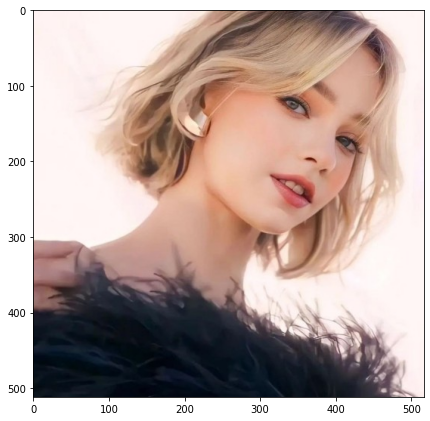

In [28]:
print_img(cv2.imread('./emma_r_rotate.png'))

- 이번 사진은 얼굴이 보다 많이 기울어져 있다. 이전에 약간 기울어진 사진은 인식했었는데, 해당 검출기가 일정 각도 이상 기울어진 모습에서는 얼굴을 인식하지 못하는 것은 아닐까?
- 기존에 얼굴을 인식했던 사진을 인위적으로 기울이고 얼굴 검출을 시도해본다.

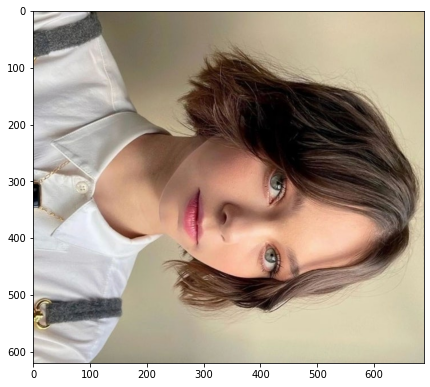

In [29]:
img = cv2.imread('./emma_r.png')
rotate_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
print_img(rotate_90)

- 앞서 정상적으로 인식했던 이미지를 기울여서 시도.

In [30]:
stickerApp(rotate_90)

Face Detection Failure


- 역시 실패.
- 이전 인식 결과를 미루어 볼때, 해당 검출기는 얼굴이 약 40도 이상 기울어지면 검출하지 못하는 문제가 있다.
---

## Case6. 멀리서 찍은 사진

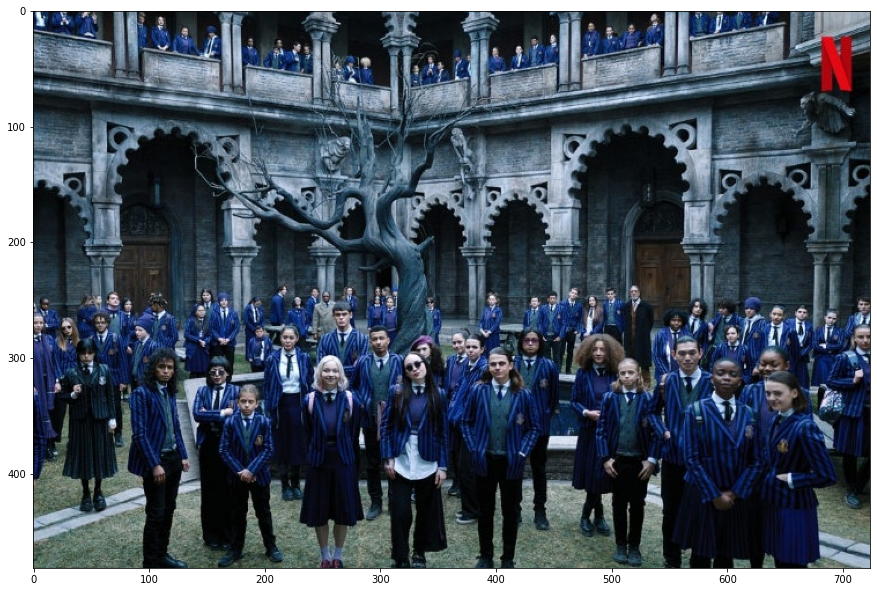

In [31]:
img = cv2.imread('./emma_far.png')

plt.figure(figsize=(15,13))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
stickerApp(img)

Face Detection Failure


- 멀리서 찍은 사진의 얼굴은 인식하지 못함.
- 즉, 눈코입이 분명하게 보이지 않는 경우 인식하지 못하는 것으로 보임. 실제 눈으로 봐도 눈동자가 보이는 인물이 없음.

## 결론

- 해당 얼굴 검출기는 일정 각도 이상 기울어지지 않고, 눈, 코, 입이 선명하게 보이는 경우에만 인식한다는 문제가 있음.
    - 여러 각도에서도 동일한 검출 성능을 보이는 검출기가 필요.
    
- 해당 스티커 적용 방식은 얼굴의 축 방향 회전에 따라 같이 회전하지 않아서 정면 사진이 아닐 경우 어색할 수 있음.
    - 얼굴의 회전값을 구하고 이에 따라 스티커를 함께 회전시켜 적용해야 함.
    
- 실제 카메라에서 실시간으로 적용되려면 초당 15 프레임 정도의 결과를 낼 수 있는 속도가 되지 않다면 사용에 불편함이 있을 것으로 보임.

- 정확도는 꽤 중요해 보임.
    - 얼굴 검출 실패율이 높아서 스티커가 잘 적용되지 않는다면 고객이 흥미를 잃고 떠날 수 있음.
    - 얼굴이 아닌데도 검출되는 경우 이상한 곳에 스티커가 적용되어 실목적을 달성할 수 없고 고객의 이탈로 이어질 수 있음.

# 회고

** Computer Vision Project 맛보기 **

- 간단한 방식으로 객체 및 랜드마크 검출 작업을 맛볼 수 있어서 좋았다.
    - 특히, 이번 프로젝트를 통해 컴퓨터 비전 관련 프로젝트를 수행하면서 만나게 될 문제점이나 이를 해결하는 과정을 경험해볼 수 있다는 점도 좋았다.


** 각 함수가 가능한 영역과 불가능한 영역을 잘 확인해야겠다. **

- `cv2.addWeighted()` 함수를 적용하기 위해 원본 이미지에 알파 채널을 추가하고, 스티커 이미지를 원본 이미지 크기의 빈 이미지 위에 찍어서 둘을 합치는 시도 등 다양한 시도를 했었다.
- 그런데 지속적으로 완전 투명해야할 부분들이 자꾸 불투명하게 나와서 당황했었다.
- 결국 해당 방식의 여러 시도는 모두 실패했다. 애초에 addWeight로는 알파값을 다루지 못하기 때문이었다.
- 함수에 입력값으로 알파 채널을 가진 이미지가 들어간다고 해서 그것을 꼭 활용한다는 의미는 아니었던 것.
- 앞으로는 함수가 가진 기능을 보다 명확히 파악하고 활용하도록 해야겠다.